In [1]:
import os,sys
from os import listdir
from os.path import isfile, join

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import numpy as np
from numpy import linalg
import skimage.util
import scipy.ndimage.filters
import scipy.misc
import scipy.io
from scipy import stats

import utils
from keras import backend as K
import keras.backend.tensorflow_backend as KTF
KTF.set_session(utils.get_session())

Using TensorFlow backend.


In [2]:
from keras.models import load_model
IQA_model = load_model('my_models/cdA_gblur.h5')

Fontconfig warning: ignoring UTF-8: not a valid region tag



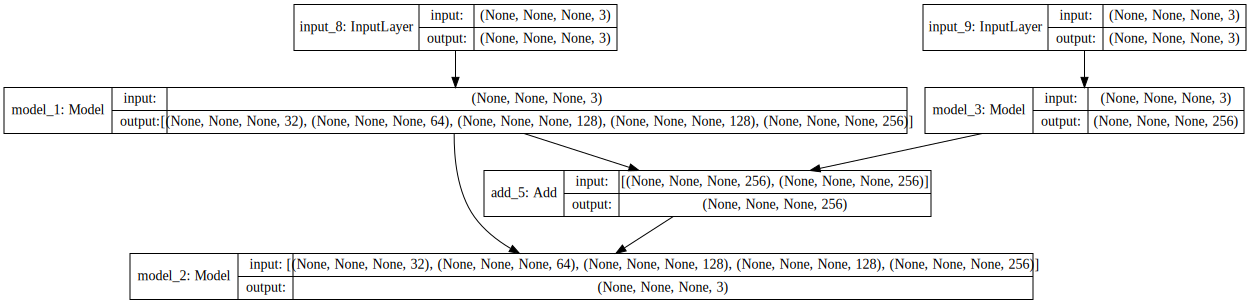

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(IQA_model, show_shapes=True).create(prog='dot', format='svg'))

In [6]:
################## Model Flow Diagram ####################
from keras.utils import plot_model
plot_model(IQA_model, to_file='my_models/cdA_gblur_model.png', show_shapes=True)

Fontconfig warning: ignoring UTF-8: not a valid region tag



In [10]:
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
model3 = layer_dict['model_3']
model3_layers = dict([layer.name, layer] for layer in model3.layers)
print model3_layers['conv2d_15'].output.shape
model3_layers

(?, ?, ?, 256)


{u'conv2d_11': <keras.layers.convolutional.Conv2D at 0x7f51180c82d0>,
 u'conv2d_12': <keras.layers.convolutional.Conv2D at 0x7f511814b350>,
 u'conv2d_13': <keras.layers.convolutional.Conv2D at 0x7f51180d9b90>,
 u'conv2d_14': <keras.layers.convolutional.Conv2D at 0x7f51180993d0>,
 u'conv2d_15': <keras.layers.convolutional.Conv2D at 0x7f511805aed0>,
 u'input_7': <keras.engine.topology.InputLayer at 0x7f5118129dd0>}

In [ ]:
from keras import backend as K
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
get_layer = K.function([layer_dict['input_4'].input, layer_dict['input_5'].input, layer_dict['input_6'].input],
                       [layer_dict['input_4'].input])

In [12]:
from keras import backend as K
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
model3 = layer_dict['model_3']
model3_layers = dict([layer.name, layer] for layer in model3.layers)
get_distortion = K.function([model3_layers['input_7'].input],
                            [model3_layers['conv2d_15'].output])

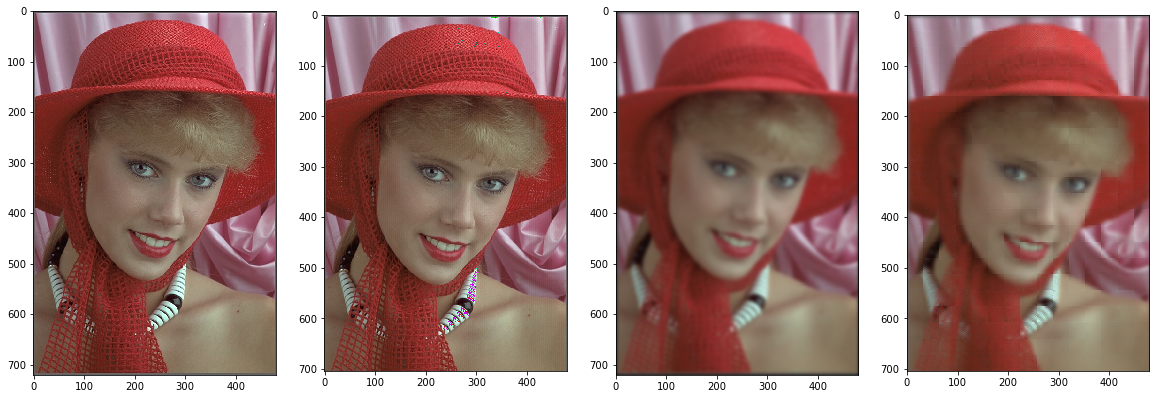

In [19]:
################################ Reconstruction ##############################
# img 162, 42, 36, 132
datadir = '/data2/rajeev/dA_IQA/data/LIVE/gblur/'
% matplotlib inline
# Clean Image
f = datadir + 'img' + str(162) + '.bmp'
Iclean = mpimg.imread(f)
Pclean = utils.getPatchesDict(Iclean, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])
# Distorted Image
f = datadir + 'img' + str(132) + '.bmp'
Idist = mpimg.imread(f)
Pdist = utils.getPatchesDict(Idist, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])

Nr = Iclean.shape[0]/32
Nc = Iclean.shape[1]/32

layer = IQA_model.predict([Pclean, Pdist])

vis_clean = utils.visualize(layer[0], [32, 32], [0, 0], [Nr, Nc], color=1)
vis_dist  = utils.visualize(layer[1], [32, 32], [0, 0], [Nr, Nc], color=1)

plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1), plt.imshow(Iclean)
plt.subplot(1, 4, 2), plt.imshow(vis_clean)
plt.subplot(1, 4, 3), plt.imshow(Idist)
plt.subplot(1, 4, 4), plt.imshow(vis_dist)
plt.show()

In [25]:
# img 162, 42, 36, 132
% matplotlib inline
f = datadir + 'img' + str(132) + '.bmp'
I = mpimg.imread(f)
print I.shape
P = utils.getPatchesDict(I, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])
print P.shape

(720, 480, 3)
(330, 32, 32, 3)


In [69]:
dist_mats = get_distortion([P])[0]
dist_mats = dist_mats.reshape((dist_mats.shape[0], np.prod(dist_mats.shape[1:])))
print dist_mats.shape
scores = np.linalg.norm(dist_mats, axis=1)
print np.mean(scores)

(384, 256)
0.712754


In [32]:
distortion.shape, np.max(distortion, axis=1).shape

((285, 256), (285,))

In [65]:
######## Score Calculation ########
datadir = '/data2/rajeev/dA_IQA/data/LIVE/gblur/'
scores = np.zeros(174)
for i in range(174):
    f = datadir + 'img' + str(i+1) + '.bmp'
    I = mpimg.imread(f)
    P = utils.getPatchesDict(I, psize=[32, 32], noPatches=4000, entropy_th=1.0, stride=[32, 32])
    dist_hidden = get_distortion([P])[0]
    distortion = dist_hidden.reshape((dist_hidden.shape[0], np.prod(dist_hidden.shape[1:])))
#    score = np.mean(np.linalg.norm(distortion, axis=1))         # 0.278
#    score = np.mean(np.max(distortion, axis=1))                 # 0.592
#    score = np.mean(np.sum(distortion!=0, axis=1))              # 0.739
#    score = np.mean(np.sum(abs(distortion), axis=1))            # 0.403
#    score = np.mean(np.sum(distortion==0, axis=1))              #-0.739

    scores[i] = score
    
    if (i+1)%30 == 0:
        string = str(i+1) + '/174' + 'images done!'
        print string
    elif i + 1 == 174:
        string = str(i+1) + '/174' + 'images done!'
        print string

scipy.io.savemat('results/gblur/QualityScores.mat', mdict = {'scores': scores})

30/174images done!
60/174images done!
90/174images done!
120/174images done!
150/174images done!
174/174images done!


In [66]:
####### Correlation Calculation ######
data = scipy.io.loadmat('../../data/LIVE/dmos.mat')
dmos = data["dmos"]
orgs = data["orgs"]
# GBLUR values
dmos = dmos[:, 634 : 808]
orgs = orgs[:, 634 : 808]

data = scipy.io.loadmat('results/gblur/QualityScores.mat')
scores = data["scores"]

distIndcs = np.where(orgs == 0)[1]
dmos = dmos[:, distIndcs]
scores = scores[:, distIndcs]

rho, pval = scipy.stats.spearmanr(scores[0, :], dmos[0, :])
scipy.io.savemat('results/gblur/CorrScores.mat', mdict = {'SROCC': rho})

string = 'Correlation Score = ' + str(rho)
print string

Correlation Score = -0.592343725398


In [57]:
dmos.shape, scores.shape

((1, 145), (1, 145))

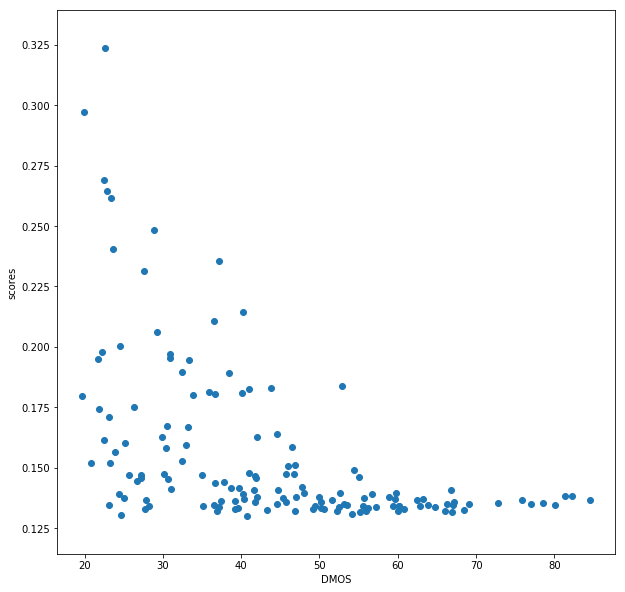

In [67]:
plt.switch_backend('agg')
plt.figure(figsize=(10, 10))
plt.scatter(dmos, scores)
plt.xlabel('DMOS')
plt.ylabel('scores')
plt.show()
plt.savefig('results/gblur/scatter.png')

In [16]:
layer_dict = dict([(layer.name, layer) for layer in IQA_model.layers])
model1 = layer_dict['model_1']
model1_layers = dict([layer.name, layer] for layer in model1.layers)

model3 = layer_dict['model_3']
model3_layers = dict([layer.name, layer] for layer in model3.layers)

model3_layers['conv2d_12'].get_weights()[0].shape

(3, 3, 32, 64)

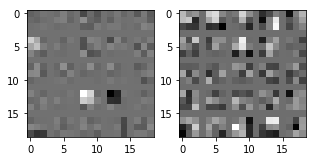

In [15]:
clean_weights = np.transpose(model1_layers['conv2d_1'].get_weights()[0])
dist_weights = np.transpose(model3_layers['conv2d_11'].get_weights()[0])

vis_w1 = utils.visualize(clean_weights, [3, 3], [1, 1], [5, 5], color=1, channels='first')
vis_w2 = utils.visualize(dist_weights, [3, 3], [1, 1], [5, 5], color=1, channels='first')

plt.figure(figsize=(5, 5))
plt.subplot(1, 2, 1), plt.imshow(utils.rgb2gray(vis_w1), cmap='gray')
plt.subplot(1, 2, 2), plt.imshow(utils.rgb2gray(vis_w2), cmap='gray')
plt.show()

In [113]:
a = np.ones((3, 4, 5))

In [114]:
b = np.transpose(a, [1, 2, 0])

In [116]:
b.shape

(4, 5, 3)